# 1. Imports and Data Preparation

In [ ]:
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd

from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import DistanceWeightedMiner
import torch, torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import roc_auc_score
from torchvision.datasets.folder import default_loader   # PIL opener
DATASET_ROOT = Path("dataset")

CLASS_ROOT = DATASET_ROOT / "classification_data"       # train/val/test live here
PAIRS_TXT  = DATASET_ROOT / "verification_pairs_val.txt"

train_tf = transforms.Compose([ # data augmentation for training
    transforms.Resize(128), transforms.CenterCrop(112), # resize to 112x112 and center crop
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),   # random flip
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1, 1] using ImageNet stats
])


def get_loader(split, batch=128, shuffle=True, workers=8):
    """
    split   : 'train', 'val', or 'test'
    batch   : mini-batch size
    workers : number of background CPU processes that feed the GPU
    """
    folder = CLASS_ROOT / f"{split}_data"
    ds = datasets.ImageFolder(folder, transform=train_tf)

    return DataLoader(  # create a DataLoader for the dataset
        ds,
        batch_size=batch,
        shuffle=shuffle,
        num_workers=workers,     # background CPU processes
        pin_memory=True,         # faster CPU→GPU copies
        persistent_workers=True, # keep workers alive between epochs
        prefetch_factor=4        # each worker queues 4 batches ahead
    )

train_loader = get_loader("train", workers=8)
val_loader   = get_loader("val", shuffle=False, workers=8)
test_loader  = get_loader("test", shuffle=False, workers=8)

n_classes = len(train_loader.dataset.classes)   # number of classes
print("classes =", n_classes)


classes = 4000


# 2. Check CUDA Availability

In [ ]:
print(torch.cuda.is_available())       # → True
print(torch.cuda.get_device_name(0))   # → NVIDIA GeForce RTX 3070 Laptop GPU
print(torch.version.cuda)              # → 12.1


True
NVIDIA GeForce RTX 3070 Laptop GPU
12.1


# 3. Load Verification Pairs and Prepare Paths

In [ ]:
pairs = pd.read_csv(PAIRS_TXT, sep=" ", header=None,
                    names=["img1","img2","label"])
pairs["img1"] = pairs["img1"].apply(lambda p: DATASET_ROOT / p)
pairs["img2"] = pairs["img2"].apply(lambda p: DATASET_ROOT / p)
VERI_DIR = Path("verification_data")


# 4. Define and Initialize Classifier Model

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"
net = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # load a pre-trained ResNet-18 model
                  # start from scratch
net.fc = nn.Linear(net.fc.in_features, n_classes)   # replace the final layer with a new one
net.to(device)  # move to GPU if available

opt_cls  = torch.optim.Adam(net.parameters(), lr=1e-3)  # optimizer for classification
ce   = nn.CrossEntropyLoss()    # loss function for classification


# 5. Print DataLoader Info

In [5]:
print("train images :", len(train_loader.dataset))
print("batch size   :", train_loader.batch_size)
print("batches/epoch:", len(train_loader))


train images : 380638
batch size   : 128
batches/epoch: 2974


# 6. Train or Load Classifier Model

In [ ]:
# ------------------------------------------------------------------
# 0.  Paths and helper
# ------------------------------------------------------------------
CKPT_DIR  = Path("models")
CKPT_FILE = CKPT_DIR / "resnet_face_cls_epoch10.pth"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

def load_classifier(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(ckpt["model_state"])
    opt_cls.load_state_dict(ckpt["optimizer_state"])
    print(f"✅  Loaded classifier from {checkpoint_path} (val acc {ckpt['val_acc']:.3%})")

# ------------------------------------------------------------------
# 1.  Either load or train
# ------------------------------------------------------------------
if CKPT_FILE.exists():
    load_classifier(CKPT_FILE)

else:
    from tqdm import tqdm   # progress bar

    EPOCHS = 10
    for epoch in range(EPOCHS):
        net.train()
        for x, y in tqdm(train_loader, desc=f"epoch {epoch}"):
            x = x.to(device, non_blocking=True) # non_blocking=True speeds up GPU transfer
            y = y.to(device, non_blocking=True)
            opt_cls.zero_grad()
            ce(net(x), y).backward()
            opt_cls.step()

        # quick val accuracy
        net.eval(); correct = total = 0
        with torch.no_grad():   # no gradients needed for validation
            for x, y in val_loader:
                preds = net(x.to(device)).argmax(1) # get class predictions
                correct += (preds.cpu() == y).sum().item()  # count correct
                total   += y.size(0)    # count total images
        val_acc = correct / total   # accuracy in [0, 1]
        print(f"epoch {epoch}: val acc = {val_acc:.3%}")

    # save once, after the final epoch
    torch.save({
        "epoch": epoch,
        "model_state": net.state_dict(),
        "optimizer_state": opt_cls.state_dict(),
        "val_acc": val_acc
    }, CKPT_FILE)
    print("💾  Saved classifier to", CKPT_FILE)



✅  Loaded classifier from models\resnet_face_cls_epoch10.pth (val acc 63.513%)


C:\Users\terif\AppData\Local\Temp\ipykernel_22136\1869090912.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


# 7. Define Embedding Network and PK Sampler

In [ ]:
from pytorch_metric_learning.samplers import MPerClassSampler
from torch.utils.data import BatchSampler
from torchvision.models import resnet50, ResNet50_Weights

class EmbNet(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)    # load a pre-trained ResNet-50 model
        self.backbone.fc = nn.Identity()    # remove the final classification layer
        self.bn = nn.BatchNorm1d(2048)           # “BN-neck” :contentReference[oaicite:4]{index=4}
        self.fc = nn.Linear(2048, dim, bias=False)  # projection head to a lower dimension
        
    def forward(self,x):
        z = self.bn(self.backbone(x))   # extract features from the backbone
        z = F.normalize(self.fc(z), dim=1)  # normalize the features and project to a lower dimension
        return z
P,K,STEPS = 16,4, 50_000    # 16 images per class, 4 classes per batch, 50k batches
train_ds  = datasets.ImageFolder(CLASS_ROOT / "train_data", transform=train_tf)
labels    = [y for _, y in train_ds.samples]    # list of class labels for each image

pk_sampler  = MPerClassSampler(labels, m=K, batch_size=P*K,
                               length_before_new_iter=len(train_ds))

sampler = MPerClassSampler(labels, m=K, 
                           length_before_new_iter=len(train_ds))

batch_sampler = BatchSampler(   # MPerClassSampler
    sampler,
    batch_size=P*K,           # 64
    drop_last=True  # drop the last batch if it has fewer than 64 images
)

train_loader = DataLoader(  # 16 images per class, 4 classes per batch
    train_ds,
    batch_sampler=batch_sampler,      
    num_workers=8, pin_memory=True
)



# 8. Initialize Embedding Model, Optimizer, and Loss

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
emb_net = EmbNet(dim=512)       # 512-dim embeddings
emb_net.to(device)
optim = torch.optim.AdamW(emb_net.parameters(), 1e-4, weight_decay=1e-4)    # AdamW optimizer
sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=STEPS)  # cosine decay scheduler

criterion = TripletMarginLoss(margin=0.3)   #  triplet loss with margin 0.3
miner = DistanceWeightedMiner() #  distance-weighted miner

# 9. Train or Load Triplet Embedding Model

In [ ]:
# ------------------------------------------------------------------
# 0.  Paths and helper for triplet model
# ------------------------------------------------------------------
CKPT_EMB = Path("models/embnet_triplet_15k.pth")


def load_embnet(path):  # load the model and optimizer state from a checkpoint
    ckpt = torch.load(path, map_location=device)
    emb_net.load_state_dict(ckpt["model_state"])
    optim.load_state_dict(ckpt["optimizer_state"])
    print(f"✅  Loaded EmbNet ({ckpt['steps']} steps, loss {ckpt['loss']:.4f})")
loss = torch.tensor(0.0)
# ------------------------------------------------------------------
# 1.  Either load or train
# ------------------------------------------------------------------
if CKPT_EMB.exists():   # if the checkpoint exists, load it
    load_embnet(CKPT_EMB)

else:
    step  = 0
    emb_net.train()

    while step < STEPS: # 50k steps
        for x, y in train_loader:          # DataLoader restarts itself every epoch
            x, y = x.to(device), y.to(device)   # move to GPU
            optim.zero_grad()         # reset gradients
            e = emb_net(x)            # e.shape = (B, 512) where B = P*K
            loss = criterion(e, y, miner(e, y)) # compute triplet loss
            loss.backward()       # backpropagate
            optim.step(); sched.step()  # update weights and scheduler
            if step % 1_000 == 0:   # print every 1000 steps
                print(f"step {step:>6}, loss {loss.item():.4f}")

            step += 1
            if step >= STEPS:   # stop after STEPS steps
                break          

    torch.save({    # save the model and optimizer state
        "steps": STEPS,
        "model_state": emb_net.state_dict(),
        "optimizer_state": optim.state_dict(),
        "loss": loss.item()          
    }, CKPT_EMB)
    print("💾  Saved EmbNet to", CKPT_EMB)


step      0, loss 0.4306
step   1000, loss 0.4129
step   2000, loss 0.3482
step   3000, loss 0.2799
step   4000, loss 0.2907
step   5000, loss 0.3990
step   6000, loss 0.3428
step   7000, loss 0.3123
step   8000, loss 0.3062
step   9000, loss 0.3035
step  10000, loss 0.3336
step  11000, loss 0.2577
step  12000, loss 0.3025
step  13000, loss 0.2498
step  14000, loss 0.2377
step  15000, loss 0.2981
step  16000, loss 0.3374
step  17000, loss 0.2809
step  18000, loss 0.3457
step  19000, loss 0.3288
step  20000, loss 0.2738
step  21000, loss 0.3670
step  22000, loss 0.2605
step  23000, loss 0.2692
step  24000, loss 0.3300
step  25000, loss 0.3466
step  26000, loss 0.3008
step  27000, loss 0.2803
step  28000, loss 0.2688
step  29000, loss 0.3829
step  30000, loss 0.3499
step  31000, loss 0.2619
step  32000, loss 0.2605
step  33000, loss 0.2121
step  34000, loss 0.2629
step  35000, loss 0.2409
step  36000, loss 0.3722
step  37000, loss 0.2158
step  38000, loss 0.2332
step  39000, loss 0.2823


# 10. Build Verification Dataset and Cache Embeddings

In [ ]:


VERI_DIR = DATASET_ROOT / "verification_data"            # absolute dir

# ---------------- dataset -----------------------------------------
class VeriSet(torch.utils.data.Dataset):    # dataset loading for verification
    def __init__(self, root, transform):
        self.paths     = list(root.rglob("*.jpg"))
        self.transform = transform  # torchvision transforms
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = default_loader(self.paths[idx])            # PIL image
        return self.transform(img), self.paths[idx]      # (tensor, Path)

# ---------------- custom collate  ---------------------------------
def collate_fn(batch):
    imgs, paths = zip(*batch)                 # two tuples
    imgs  = torch.stack(imgs, 0)              # (B,3,112,112) tensor
    paths = list(paths)                       # keep Paths as-is
    return imgs, paths

# ---------------- loader ------------------------------------------
veri_ds     = VeriSet(VERI_DIR, train_tf)
veri_loader = DataLoader(
    veri_ds,
    batch_size=128,
    shuffle=False,
    num_workers=0,          # single process is fine for cached images
    pin_memory=True,
    collate_fn=collate_fn   # ← key addition
)

relkey = lambda p: str(p.relative_to(DATASET_ROOT))      # helper

# ---------------- embed & cache -----------------------------------
emb_cache = {}
emb_net.eval()
# 1. build the cache with relative-string keys
with torch.no_grad():
    for batch, paths in veri_loader:
        batch = batch.to(device, non_blocking=True)
        vecs  = emb_net(batch).cpu()
        for p, v in zip(paths, vecs):
            emb_cache[relkey(p)] = v


# 11. Compute Cosine Similarity AUC for Triplet Embeddings

In [ ]:


scores, labels = [], []
for _, r in pairs.iterrows():
    v1 = emb_cache[relkey(r.img1)]
    v2 = emb_cache[relkey(r.img2)]
    sim = F.cosine_similarity(v1, v2, dim=0)   # ← specify dim=0
    scores.append(sim.item())
    labels.append(r.label)

print("Linear Metric AUC =", roc_auc_score(labels, scores))



AUC = 0.941119263355932


# 12. Extract Features from Classifier and Compute AUC

In [ ]:
# -----------------------------------------------
# helper to extract 512-d features from 'net'
# -----------------------------------------------
class ClassifierFeats(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = nn.Sequential(*list(model.children())[:-1])  # everything but the final fc layer
    def forward(self, x):
        x = self.backbone(x)            # (B,512,1,1)
        x = torch.flatten(x, 1)         # (B,512)
        return torch.nn.functional.normalize(x, dim=1)

cls_feat = ClassifierFeats(net).to(device).eval()

# build a second cache
cls_cache = {}
with torch.no_grad():
    for batch, paths in veri_loader:
        batch = batch.to(device, non_blocking=True)
        vecs  = cls_feat(batch).cpu()            # (B,512)
        for p, v in zip(paths, vecs):
            cls_cache[relkey(p)] = v

# compute AUC
scores_cls, labels = [], []
for _, r in pairs.iterrows():
    v1 = cls_cache[relkey(r.img1)]
    v2 = cls_cache[relkey(r.img2)]
    scores_cls.append(F.cosine_similarity(v1, v2, dim=0).item())
    labels.append(r.label)

print("Classifier-embedding AUC =", roc_auc_score(labels, scores_cls))


Classifier-embedding AUC = 0.8822396622338298


# 13. Plot ROC Curves for Classifier and Triplet Embeddings

In [ ]:
from sklearn.metrics import roc_curve, auc

# ------------ classifier -----------------
fpr_cls, tpr_cls, _ = roc_curve(labels, scores_cls)
auc_cls = auc(fpr_cls, tpr_cls)

# ------------ triplet embedding ----------
fpr_emb, tpr_emb, _ = roc_curve(labels, scores)
auc_emb = auc(fpr_emb, tpr_emb)

print(f"Classifier AUC  : {auc_cls:.4f}")
print(f"Triplet  AUC    : {auc_emb:.4f}")


Classifier AUC  : 0.8822
Triplet  AUC    : 0.9411


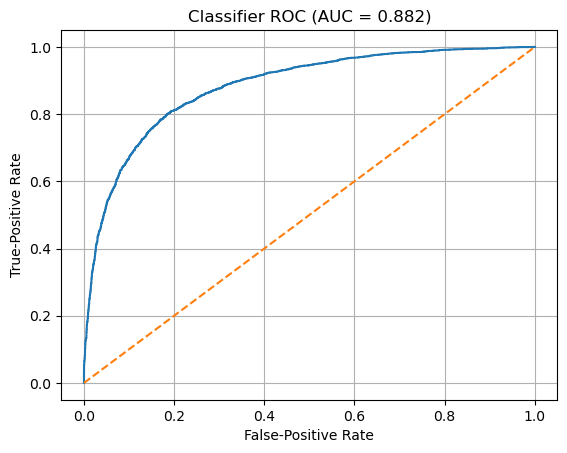

In [19]:
import matplotlib.pyplot as plt

plt.figure()                       # one dedicated figure
plt.plot(fpr_cls, tpr_cls)
plt.plot([0, 1], [0, 1], linestyle="--")   # random-guess line
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title(f"Classifier ROC (AUC = {auc_cls:.3f})")
plt.grid(True)
plt.show()


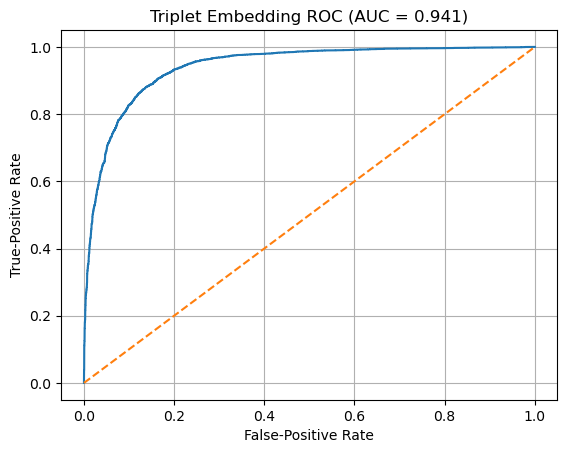

In [20]:
plt.figure()                       # separate figure
plt.plot(fpr_emb, tpr_emb)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title(f"Triplet Embedding ROC (AUC = {auc_emb:.3f})")
plt.grid(True)
plt.show()


In [ ]:
# Euclidean AUC for classifier embeddings
scores_cls_euc, labels_cls = [], []
for _, r in pairs.iterrows():
    v1 = cls_cache[relkey(r.img1)]
    v2 = cls_cache[relkey(r.img2)]
    sim = -torch.norm(v1 - v2, p=2).item()   # negative so "higher is more similar"
    scores_cls_euc.append(sim)
    labels_cls.append(r.label)

auc_cls_euc = roc_auc_score(labels_cls, scores_cls_euc)
print(f"Classifier AUC (Euclidean) = {auc_cls_euc:.4f}")


Classifier AUC (Euclidean) = 0.8822


In [ ]:
# Euclidean-distance baseline
from sklearn.metrics import roc_auc_score

scores_euc, labels_euc = [], []
for _, r in pairs.iterrows():
    v1 = emb_cache[relkey(r.img1)]
    v2 = emb_cache[relkey(r.img2)]

    # negative Euclidean distance (higher = more similar)
    sim_euc = -torch.norm(v1 - v2, p=2).item()
    scores_euc.append(sim_euc)
    labels_euc.append(r.label)

auc_euc = roc_auc_score(labels_euc, scores_euc)
print(f"Triplet AUC (Euclidean) = {auc_euc:.4f}")


AUC (Euclidean) = 0.9411


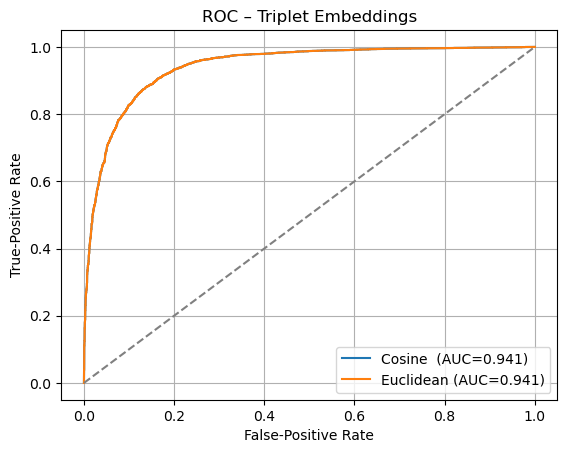

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# cosine (already have scores / labels)
fpr_c, tpr_c, _ = roc_curve(labels, scores)
auc_c = auc(fpr_c, tpr_c)

# euclidean
fpr_e, tpr_e, _ = roc_curve(labels_euc, scores_euc)
auc_e = auc(fpr_e, tpr_e)

plt.figure()
plt.plot(fpr_c, tpr_c, label=f"Cosine  (AUC={auc_c:.3f})")
plt.plot(fpr_e, tpr_e, label=f"Euclidean (AUC={auc_e:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC – Triplet Embeddings")
plt.legend()
plt.grid(True)
plt.show()
